# Import Module

In [1]:
# Import module

!pip install opendatasets
import opendatasets as od
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import os

This dataset is well structured for most deep learning frameworks. It is organized into train, val, and test folders, which contains subfolders of the classes of pneumonia (normal, pneumonia), each containing the respective jpeg images.

# Download Data

In [2]:
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
data_dir = '/content/chest-xray-pneumonia/chest_xray/chest_xray'
classes = os.listdir(data_dir + "/train")
pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
normal_files = os.listdir(data_dir + "/train/NORMAL")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: peihanl
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:10<00:00, 232MB/s]


In [3]:
# Resize and data augmentation
dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                           ]))

# dataset = ImageFolder(data_dir+'/train', 
#                       transform=tt.Compose([tt.Resize(255),
#                                             tt.CenterCrop(224),
#                                             tt.ToTensor()
#                                            ]))

We can get the classes by using the `.classes` on the dataset.

<a id='Preparing_data'></a>
# Preparing Training Set and Validation Set


In [4]:
# Split training set and validation set
train_size = round(len(dataset)*0.7) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3651, 1565)

In [5]:
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
# Set GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Helper Function

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}
    optimizer = opt_func(model.parameters(), lr)
    best_loss = 100

    for epoch in range(epochs):
        
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']           
            train_outputs.append(outputs)

            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                

            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()                                   
            optimizer.zero_grad()   

        val_results = evaluate(model, val_loader)
        
        # Save best loss
        if val_results['val_loss'] < best_loss and epoch  >= 10:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}

        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss

class PneumoniaModelBase(nn.Module):
    
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                     
        loss = F.cross_entropy(out, labels, weight=weight)    
        acc,preds = accuracy(out, labels)               
        
        return {'train_loss': loss, 'train_acc':acc}
       
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]      
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['train_acc'] for x in outputs] 
        epoch_acc = torch.stack(batch_accs).mean()  
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      
        loss = F.cross_entropy(out, labels)                 
        acc,preds = accuracy(out, labels)         
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]       
        epoch_loss = torch.stack(batch_losses).mean()      
        batch_accs = [x['val_acc'] for x in outputs]   
        epoch_acc = torch.stack(batch_accs).mean()   
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()          
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}      

# Define Resnet Model

In [8]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
class Resnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Unfreeze the last two layers of resnet50
        # layer = 0
        # for child in self.network.children():
        #   layer += 1
        #   if layer < 9:
        #         for param in child.parameters():
        #           param.requires_grad = False
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)

# Train

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(Resnet(), device)

In [ ]:
epochs = 20
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)

In [ ]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1], train_loss: 0.1479, train_acc: 0.9444, val_loss: 0.2418, val_acc: 0.8893
Epoch [2], train_loss: 0.0754, train_acc: 0.9712, val_loss: 0.0773, val_acc: 0.9715
Epoch [3], train_loss: 0.0503, train_acc: 0.9801, val_loss: 0.0646, val_acc: 0.9773
Epoch [4], train_loss: 0.0545, train_acc: 0.9809, val_loss: 0.1080, val_acc: 0.9631
Epoch [5], train_loss: 0.0269, train_acc: 0.9911, val_loss: 0.0696, val_acc: 0.9689
Epoch [6], train_loss: 0.0472, train_acc: 0.9802, val_loss: 0.0838, val_acc: 0.9737
Epoch [7], train_loss: 0.0682, train_acc: 0.9784, val_loss: 0.1108, val_acc: 0.9622
Epoch [8], train_loss: 0.0809, train_acc: 0.9754, val_loss: 0.0978, val_acc: 0.9613
Epoch [9], train_loss: 0.0880, train_acc: 0.9711, val_loss: 0.0614, val_acc: 0.9745
Epoch [10], train_loss: 0.0486, train_acc: 0.9844, val_loss: 0.0726, val_acc: 0.9697
Epoch [11], train_loss: 0.0296, train_acc: 0.9884, val_loss: 0.0823, val_acc: 0.9697
Epoch [12], train_loss: 0.0315, train_acc: 0.9856, val_loss: 0.0622, val_a

In [ ]:
# Save and load model
bestmodel = {'model': Resnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'PneumoniaResnet.pth')

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [11]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [14]:
model = load_checkpoint("/content/PneumoniaResnet.pth")

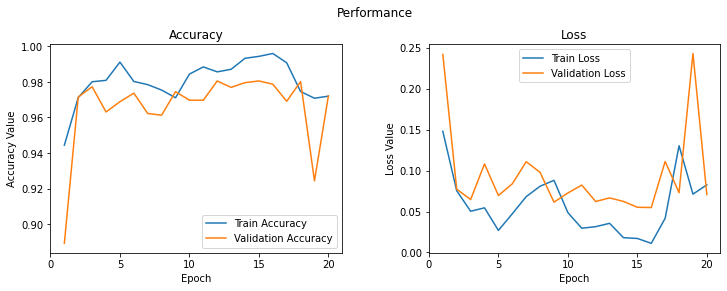

In [ ]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Evaluation


In [15]:
def test_predict(model, test_loader):
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [16]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                ]))

In [18]:
test_dl = DataLoader(test_dataset, batch_size=256)
# test_dl = DeviceDataLoader(test_dl, device)
model = load_checkpoint("/content/PneumoniaResnet.pth")
preds,labels = test_predict(model, test_dl)

test_loss: 0.4538, test_acc: 0.9115


In [23]:
# cm  = confusion_matrix(labels, preds)
# plt.figure()
# plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
# plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
# plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
# plt.xlabel('Predicted Label',fontsize=18)
# plt.ylabel('True Label',fontsize=18)
# plt.show()

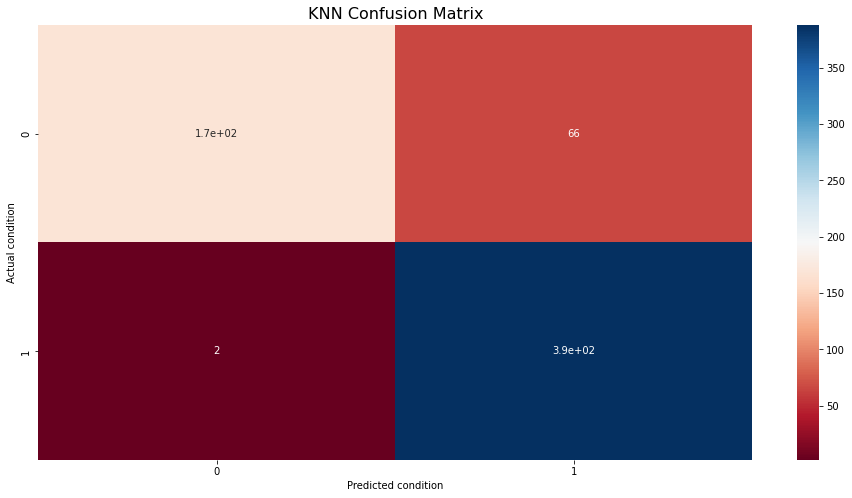

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
confusion_matrix_df = pd.DataFrame(confusion_matrix(labels, preds))
plt.figure(figsize=(16,8))
sns.heatmap(confusion_matrix_df, cmap="RdBu", annot=True)
plt.title('KNN Confusion Matrix', fontsize=16)
plt.xlabel("Predicted condition")
plt.ylabel("Actual condition")
plt.savefig("Resnet Confusion Matrix.png")
plt.show()

In [25]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       234
           1       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624

